In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import tensorflow as tf

In [2]:
# %load nn17_ex3_main.py
#!/usr/bin/env python3

# Import Data

# plt.close('all')  # if you like

# load dataset

with open('isolet_crop_train.pkl', 'rb') as f:
    train_data = pkl.load(f)

with open('isolet_crop_test.pkl', 'rb') as f:
    test_data = pkl.load(f)

X_train, y_train = train_data
X_test, y_test = test_data

y_train = y_train - 1 
y_test = y_test - 1  

# normalize the data and check the results

# ...

#print(X_train.mean(axis=0))
#print(X_train.var(axis=0))

# split the data sets, etc.

# ...

In [3]:
# Get training Data statistics

# Number of Training examples
n_train = len(X_train)
# Number of Testing examples
n_test = len(X_test)
# Number of Training features
n_TrainFeatures = len(X_train[0])
# Number of Testing features (should be equal to that of training)
n_TestFeatures = len (X_test[0])
# Number of Training classes
n_TrainClasses =  len(np.unique(y_train))
# Number of Testing Classes (should be equal to that of training)
n_TestClasses = len(np.unique(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("....")
print("Number of Training features =", n_TrainFeatures)
print("Number of Testing features =", n_TestFeatures)
print("....")
print("Number of Training Classes =", n_TrainClasses)
print("Number of Testing Classes =", n_TestClasses)

Number of training examples = 6238
Number of testing examples = 1559
....
Number of Training features = 300
Number of Testing features = 300
....
Number of Training Classes = 26
Number of Testing Classes = 26


##  a) Make yourself familiar with the dataset. Normalize each feature to zero mean and unitvariance.

In [4]:
#X_train, y_train = train_data
#X_test, y_test = test_data

X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)

# Training data normalization
X_train = (X_train - X_mean) / X_std

# Testing data normalization
X_test = (X_test - X_mean) / X_std

# Split Data

In [5]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train,y_train)

from sklearn.model_selection import train_test_split
# First split in 70% -- 30%
X_train2, X_temp, y_train2, y_temp  = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

#Split the 30% into half to get 15% -- 15% (from X_train)for validation and early stop
X_validation, X_stop, y_validation, y_stop = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

n_input = len(X_train2)

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_train2.shape)
print(y_train2.shape)
print(X_validation.shape)
print(y_validation.shape)
print(X_stop.shape)
print(y_stop.shape)

(6238, 300)
(6238,)
(4366, 300)
(4366,)
(936, 300)
(936,)
(936, 300)
(936,)


## one-out-of-K coding

In [7]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 300))
y = tf.placeholder(tf.int32,(None))
one_hot_y = tf.one_hot(y, 26)


# Network

In [8]:

def Train_Classifier(x, Layers = [20,26],activation = tf.sigmoid):
    
    print("In Traffic Sign Classifier.......................................................................... \n")
   
    M = x.shape[1] #300
    C = Layers[-1] #26
    n_layers = len(Layers)
    Layers = np.insert(Layers,0,M)
    
    W = []
    b = []
    a = []
    z = [] 

    for i in range(n_layers):
        W.append(tf.Variable(tf.truncated_normal([Layers[i], Layers[i+1]]),name='weights_{}'.format(i)))
        b.append(tf.Variable(tf.zeros(Layers[i+1]),name='bias_{}'.format(i)))
        if i == 0:
            a.append(tf.add(tf.matmul(x,W[i]),b[i]))
        else:
            a.append(tf.add(tf.matmul(z[i-1],W[i]),b[i]))
        z.append(activation(a[i]))
    logits =  a[-1]
    
    return logits

In [46]:
Rate = {0: 0.1, 1: 0.008, 2: 0.005}

In [10]:
Logits = []
#optimizers = []
#rates = []
C = n_TrainClasses

Algo = {0:tf.sigmoid, 1:tf.tanh,2:tf.nn.relu}
#Optzr = {0: tf.train.GradientDescentOptimizer, 1: tf.train.RMSPropOptimizer,
#         2: tf.train.AdamOptimizer}
#Rate = {0: 0.1, 1: 0.008, 2: 0.005}

#Cross_entropys = []

for i in range(len(Algo)):
    #print(i)
    Logits.append(Train_Classifier(x,[20,C], Algo[i]))
    
    

In Traffic Sign Classifier.......................................................................... 

In Traffic Sign Classifier.......................................................................... 

In Traffic Sign Classifier.......................................................................... 



In [12]:
len(Logits)

3

In [13]:
rate = 0.1 # learning rate

EPOCHS = 5
BATCH_SIZE = 40
logits = Logits[0]
#logits = Train_Classifier(x,[100,26],activation = 1)#,n_TrainFeatures, n_TrainClasses)
logits = Logits[0]
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

#optimizer = tf.train.RMSPropOptimizer(0.002)
#optimizer = tf.train.AdamOptimizer(0.005)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=rate)

training_operation = optimizer.minimize(loss_operation)

#tf.train.RMSPropOptimizer(rate)
#tf.train.AdamOptimizer()

In [14]:
correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(one_hot_y,1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver =tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples
    

In [27]:
def network(logits):
    #sess.run(tf.global_variables_initializer())
    #tf.reset_default_graph()
    x = tf.placeholder(tf.float32, (None, 300))
    y = tf.placeholder(tf.int32,(None))
    one_hot_y = tf.one_hot(y, 26)
    
    print(logits)
    rate = 0.1 # learning rate

    EPOCHS = 5
    BATCH_SIZE = 40
    #logits = Logits[0]
    #logits = Train_Classifier(x,[100,26],activation = 1)#,n_TrainFeatures, n_TrainClasses)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
    loss_operation = tf.reduce_mean(cross_entropy)

    #optimizer = tf.train.RMSPropOptimizer(0.002)
    #optimizer = tf.train.AdamOptimizer(0.005)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=rate)

    training_operation = optimizer.minimize(loss_operation)
    
    
    correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(one_hot_y,1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    saver =tf.train.Saver()
    print("Initialized")

In [65]:
Logits

[<tf.Tensor 'Add_1:0' shape=(?, 26) dtype=float32>,
 <tf.Tensor 'Add_3:0' shape=(?, 26) dtype=float32>,
 <tf.Tensor 'Add_5:0' shape=(?, 26) dtype=float32>]

In [ ]:
a = []

In [64]:
save_file = './modelTest1.ckpt'
Valid_acc_lists = {0:a, 1:b, 2:c}
Train_acc_lists = {0:a, 1:b, 2:c}
EarlyStopping_acc_lists = {0:a, 1:b, 2:c}
for j in range(len(Logits)):
    print ("------------------------------------------------------------------------",j)
    network(Logits[j])
    
    #np.array(train_acc_list)
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train2)

        TempValidat_acc_list = []
        TempTrain_acc_list = []
        TempEarlyStopping_acc_list = []

        validat_acc_list = []
        train_acc_list = []
        earlyStoping_acc_list = []

        earlyStoppingMax = -1

        print("Training...")
        print()

        #logits = (Train_Classifier(x,[20,C], Algo[j]))
        #network(logits)
        for i in range(EPOCHS):
            """
            if len(validat_acc_list) > 1:
                if validat_acc_list[-1] < validat_acc_list[-2] - 1e-3:
                    print("#############STOP################")
                    break
            """ 
            X_train21, y_train21 = shuffle(X_train2,y_train2)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train21[offset:end], y_train21[offset:end]
                #logits = Logits[j]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
                #print(logits)

            validation_accuracy = evaluate(X_validation, y_validation)
            training_accuracy = evaluate(X_train2, y_train2)
            earlyStoping_accuracy = evaluate(X_stop,y_stop)

            #if earlyStoppingMax < earlyStoping_accuracy:
                #earlyStoppingMax = earlyStoping_accuracy
                #print('Best so far = {} on iteration {}'.format(earlyStoppingMax,i))
                #saver.save(sess,save_file)
                #print(sess.run(tempw))

            validat_acc_list.append(validation_accuracy)
            train_acc_list.append(training_accuracy)
            earlyStoping_acc_list.append(earlyStoping_accuracy)
            
            """
            TempValidat_acc_list.append(validation_accuracy)
            TempTrain_acc_list.append(training_accuracy)
            TempEarlyStopping_acc_list.append(earlyStoping_accuracy)
            

            
            #if i%1 == 0:
            validat_acc_list.append(np.mean(TempValidat_acc_list))
            TempValidat_acc_list = []

            train_acc_list.append(np.mean(TempTrain_acc_list))
            TempTrain_acc_list = []           

            earlyStoping_acc_list.append(np.mean(TempEarlyStopping_acc_list))
            TempEarlyStopping_acc_list = []  
            """
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        Valid_acc_lists[j] = validat_acc_list
        Train_acc_lists[j] = train_acc_list
        EarlyStopping_acc_lists[j] = earlyStoping_acc_list
        




        #saver.save(sess, save_file)
        #print("Model saved")

------------------------------------------------------------------------ 0
Tensor("Add_1:0", shape=(?, 26), dtype=float32)
Initialized
Training...

EPOCH 1 ...
Validation Accuracy = 0.101
EPOCH 2 ...
Validation Accuracy = 0.154
EPOCH 3 ...
Validation Accuracy = 0.196
EPOCH 4 ...
Validation Accuracy = 0.239
EPOCH 5 ...
Validation Accuracy = 0.277
------------------------------------------------------------------------ 1
Tensor("Add_3:0", shape=(?, 26), dtype=float32)
Initialized
Training...

EPOCH 1 ...
Validation Accuracy = 0.096
EPOCH 2 ...
Validation Accuracy = 0.184
EPOCH 3 ...
Validation Accuracy = 0.229
EPOCH 4 ...
Validation Accuracy = 0.268
EPOCH 5 ...
Validation Accuracy = 0.298
------------------------------------------------------------------------ 2
Tensor("Add_5:0", shape=(?, 26), dtype=float32)
Initialized
Training...

EPOCH 1 ...
Validation Accuracy = 0.130
EPOCH 2 ...
Validation Accuracy = 0.203
EPOCH 3 ...
Validation Accuracy = 0.263
EPOCH 4 ...
Validation Accuracy = 0.

In [57]:
Valid_acc_lists[0]


[0.10042735192383456,
 0.14636752353264734,
 0.21901709583197904,
 0.27350427388635457,
 0.3226495757062211]

In [43]:
a = 0# np.array(train_acc_list)
b = np.array(validat_acc_list)
c = np.array(earlyStoping_acc_list)

abc = {0: a, 1:b, 2:c}

In [45]:
abc[0] = np.array(train_acc_list)

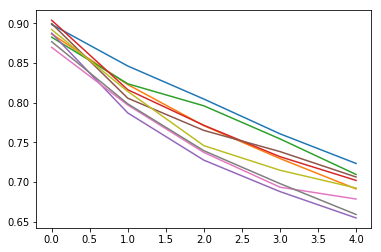

In [65]:
for i in range (len(Valid_acc_lists)):
    plt.plot(1- np.array(Valid_acc_lists[i]))
    plt.plot(1- np.array(Train_acc_lists[i]))
    plt.plot(1- np.array(EarlyStopping_acc_lists[i]))
    
plt.show()

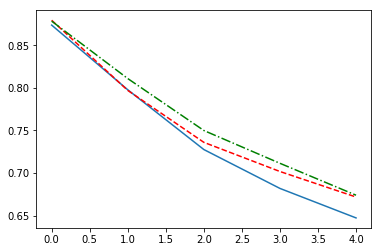

In [29]:
plt.plot(1-np.array(train_acc_list))
plt.plot(1-np.array(validat_acc_list),'r--')
plt.plot(1-np.array(earlyStoping_acc_list),'g-.')
plt.show()

In [ ]:
plt.plot(validat_acc_list)
plt.show()

In [ ]:
plt.plot(validat_acc_list)
plt.show()

In [ ]:
plt.plot(earlyStoping_acc_list)
plt.show()

In [ ]:
plt.plot(earlyStoping_acc_list)
plt.show()

In [ ]:

#tf.reset_default_graph()
n_hidden_layer1 =20 

n_input1 = n_TrainFeatures #300
n_classes = n_TrainClasses #26
# n_input1, n_hidden_layer1 n_classes

tf.reset_default_graph()

layer1_W = tf.Variable(tf.truncated_normal([n_input1, n_hidden_layer1]),name='weights_1')
layer1_b = tf.Variable(tf.zeros(n_hidden_layer1),name='bias_1')


# Layer 2: Output layer
layer2_W = tf.Variable(tf.truncated_normal([n_hidden_layer1, n_classes]),name='weights_2')
layer2_b = tf.Variable(tf.zeros(n_classes),name='bias_2')

saver = tf.train.Saver()
with tf.Session() as sess:

    saver.restore(sess, save_file)
    #evaluate(X_stop,y_stop);
    temp = (sess.run(layer1_W))
print('Loaded Weights successfully.')

In [ ]:
import tensorflow as tf

tf.reset_default_graph()

save_file = './Test2.ckpt'

# Two Tensor Variables: weights and bias

bias = tf.Variable(tf.truncated_normal([3]))
weights = tf.Variable(tf.truncated_normal([2, 3]))

saver = tf.train.Saver()

# Print the name of Weights and Bias
print('Save Weights: {}'.format(weights))
print('Save Bias: {}'.format(bias))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.save(sess, save_file)

# Remove the previous weights and bias
tf.reset_default_graph()

# Two Variables: weights and bias
bias = tf.Variable(tf.truncated_normal([3]))
weights = tf.Variable(tf.truncated_normal([2, 3]))

saver = tf.train.Saver()

# Print the name of Weights and Bias
print('Load Weights: {}'.format(weights))
print('Load Bias: {}'.format(bias))

with tf.Session() as sess:
    # Load the weights and bias - No Error
    saver.restore(sess, save_file)

print('Loaded Weights and Bias successfully.')

In [ ]:
import tensorflow as tf

tf.reset_default_graph()

save_file = './Test.ckpt'

# Two Tensor Variables: weights and bias
weights = tf.Variable(tf.truncated_normal([2, 3]), name='weights_0')
bias = tf.Variable(tf.truncated_normal([3]), name='bias_0')

saver = tf.train.Saver()

# Print the name of Weights and Bias
print('Save Weights: {}'.format(weights.name))
print('Save Bias: {}'.format(bias.name))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.save(sess, save_file)

# Remove the previous weights and bias
tf.reset_default_graph()

# Two Variables: weights and bias
bias = tf.Variable(tf.truncated_normal([3]), name='bias_0')
weights = tf.Variable(tf.truncated_normal([2, 3]) ,name='weights_0')

saver = tf.train.Saver()

# Print the name of Weights and Bias
print('Load Weights: {}'.format(weights.name))
print('Load Bias: {}'.format(bias.name))

with tf.Session() as sess:
    # Load the weights and bias - No Error
    saver.restore(sess, save_file)

print('Loaded Weights and Bias successfully.')